In [51]:
from Limma import batchEffectCorrection
import pandas as pd
from utils.utility_functions import pca_plot

In [2]:
help(batchEffectCorrection)

Help on function batchEffectCorrection in module Limma:

batchEffectCorrection(D, M, method='ls', debug=False)
    A python implementation for removeBatchEffect, a R function apart of LIMMA (linear models for Microarrays data) package.
    Removes unwanted batch effects by fitting a linear model to the data and removing the component due to batch effects.

    Parameters
    ---------
    D: pd.DataFrame
        - Data Matrix of shape (n_signals, n_samples)
    M: pd.DataFrame
        - MetaData Matrix, can have other covariate information, needs to have batch variable defined
    debug: bool:
        - If True, return local variables for debugging purposes (default: False)
    method: str {ls ...}
        - Apply OLS to each signal
        - Could add other options such as WLS, GLS

    Returns
    -------
    pd.DataFrame
        - Batch-corrected data with same shape as input D (n_signals, n_samples)
    References
    -------
    [1] Smyth, G. K. (2004). Linear models and empirical

## Sample Data

In [ ]:
D = pd.read_csv("Data/2-area_data_detection_filter.csv").rename(columns={"Unnamed: 0":"sample_name"}).set_index("sample_name")
M = pd.read_csv("Data/sample_metadata.csv").set_index('sample_name')[["sample_type","batch"]]
print(f'n_samples,n_signals = {D.shape}')
print(f'number of batches= {pd.unique(M['batch'])}')
M.head() # 200 samples, 10344 signals across 2 batches

n_samples,n_signals = (200, 10344)
number of batches= [1 2]


,sample_type,batch
sample_name,,
AOU_NIST_001,nist,1
AOU_HHEAR_P1_001,hhear p1,1
AOU_SP_001,sp,1
AOU_S_0001,study,1
AOU_S_0002,study,1


## Batch Effect Correction

In [20]:
results = batchEffectCorrection(D.T,M,debug=True)

- Design Matrix/Model Matrix/Regressor Matrix - A matrix of values of explanatory variabiles of a set of objects

- In our case we only have two explanatory variables to model (sample_type and batch) + the intercept 

- We use deviation encoding to encode categorical variables, this ensures that no level acts as the reference level. Deviation encoding is useful in linear models because it helps to handle multicollinearity issues an makes the coefficients interpretable

In [42]:
#pasty.dmatrix('1 + C(batch,Sum) + C(sample_type,Sum)') - linear model equation used to model batch effects and sample_type
results['design'] #deviation encoding of batch and sample type categorical variables creates 6 new variables for the model to use

DesignMatrix with shape (200, 6)
  Columns:
    ['Intercept',
     'C(batch, Sum)[S.1]',
     'C(sample_type, Sum)[S.hhear p1]',
     'C(sample_type, Sum)[S.hhear p2]',
     'C(sample_type, Sum)[S.nist]',
     'C(sample_type, Sum)[S.sp]']
  Terms:
    'Intercept' (column 0)
    'C(batch, Sum)' (column 1)
    'C(sample_type, Sum)' (columns 2:6)
  (to view full data, use np.asarray(this_obj))

- Once the design matrix is set up, the coefficents/weights/params are found using Oridinary Least Squares 

- OLS minimizes the SSE of a given signal across samples. 

- Parameters pertaining to batch are then calculated for every signal (in every sample) and subtracted accordingly

In [41]:
#Stored OLS models 
results['models'][:5]

In [37]:
#Parameters of Stored Models corresponding to batch
results['batch_params']

array([[-1.03430685],
       [ 1.03192222],
       [-1.51707363],
       ...,
       [ 0.12343251],
       [-0.13916916],
       [-0.05359292]])

In [40]:
#Matrix multiplication of the batch parameters(coefficeints) with their corresponding encodings in the design matrix 
# -- yields the portion of signal intensity attributed to batch, this is just subtracted out 
results['batch_effect']

array([[-1.03430685,  1.03192222, -1.51707363, ...,  0.12343251,
        -0.13916916, -0.05359292],
       [ 1.03430685, -1.03192222,  1.51707363, ..., -0.12343251,
         0.13916916,  0.05359292],
       [-1.03430685,  1.03192222, -1.51707363, ...,  0.12343251,
        -0.13916916, -0.05359292],
       ...,
       [ 1.03430685, -1.03192222,  1.51707363, ..., -0.12343251,
         0.13916916,  0.05359292],
       [-1.03430685,  1.03192222, -1.51707363, ...,  0.12343251,
        -0.13916916, -0.05359292],
       [ 1.03430685, -1.03192222,  1.51707363, ..., -0.12343251,
         0.13916916,  0.05359292]])

## PCA Plot

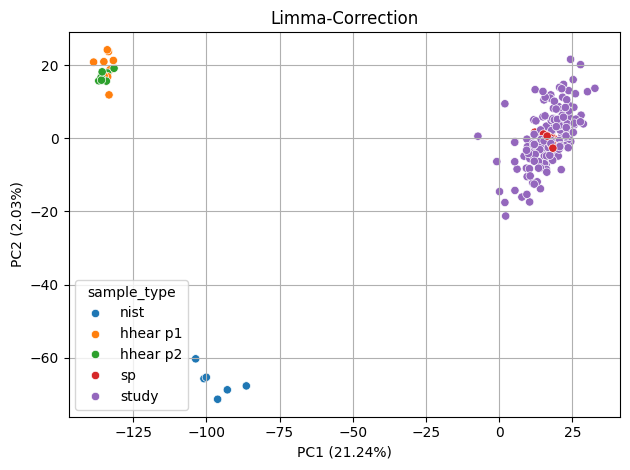

In [53]:
pca_plot(results['adjusted_D'].T,M,title="Limma-Correction")